## This notebook is an implementation of the article: " *Automatic image-based segmentation of the heart from CT scans* " by Jorge Larrey-Ruiz et al.


## <font color=green> Import Libraries </font>

In [1]:
import numpy as np
import pandas as pd
import pydicom 
import os

import scipy
import matplotlib.pyplot as plt
import seaborn as sns

from skimage import measure, morphology
from skimage.measure import label 

## <font color=green> Load CT scan </font>

---

In [2]:
def load_CT_scan(path, force = False):
    
    slices = []
    for s in os.listdir(path):
        
        if s[:1] == '.':
            continue
        
        slices.append(pydicom.read_file(path + '/' + s, force = force))
        
    #Sort slices per Instance Number
    try: slices.sort(key = lambda x: int(x.InstanceNumber))
    except: AttributeError
    return(slices)

--- 

In [3]:
CT_scan = load_CT_scan(path = '/Users/stefanoskarageorgiou/Desktop/CT_Scan', force=True)

In [6]:
print("This patient's CT scan comprises of ",len(CT_scan)," CT slices.")

This patient's CT scan comprises of  40  CT slices.


In [45]:
def multiple_plots(images_list, display_step = 0): 
    length_of_list = len(images_list)

    if length_of_list == 0:
        return('List is empty')
    
    rows = int(length_of_list / 5)
    
    fig, ax = plt.subplots(nrows = rows if length_of_list%5 == 0 else rows + 1 , ncols = 5, figsize = (20,15))
    counter = 0
    
    for i in range(rows):
        for j in range(5):
            
            title_index = counter + 1 
            ax[i,j].imshow(images_list[counter], cmap ='gray')
            ax[i,j].set_title('Slice %d' % title_index)
            ax[i,j].axis('off')
            counter += 1
    
    if (length_of_list / 5) != rows:
        
        
            for j in range(length_of_list%6):
            
                title_index = counter + 1 
                ax[rows,j].imshow(images_list[counter], cmap ='gray')
                ax[rows,j].set_title('Slice %d' % title_index)
                ax[rows,j].axis('off')
                counter += 1
           
    plt.show()

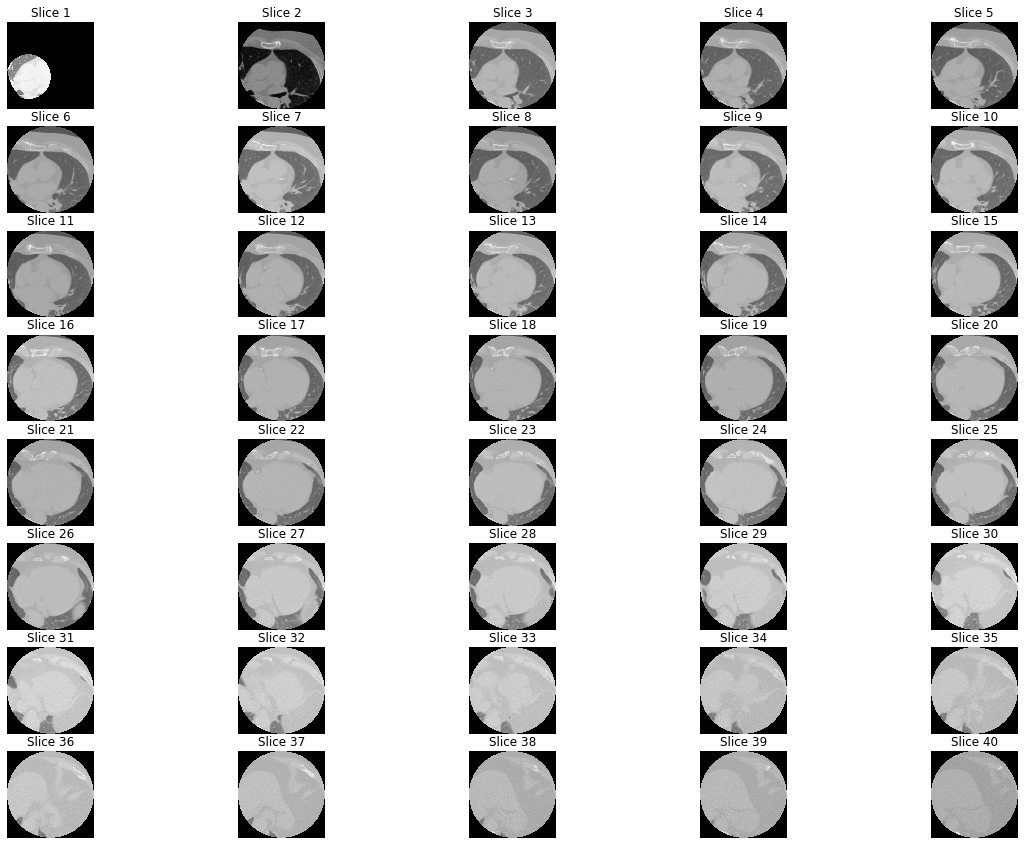

In [46]:
ct_slices = []
for i in range(len(CT_scan)):
    ct_slices.append(CT_scan[i].pixel_array)

multiple_plots(ct_slices)

## <font color=green> Preprocessing </font>

In [47]:
CT_slice = ct_slices[1]

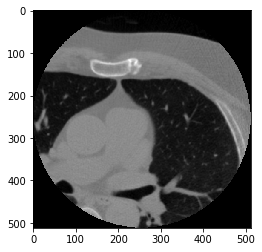

In [48]:
plt.imshow(CT_slice, cmap = 'gray');

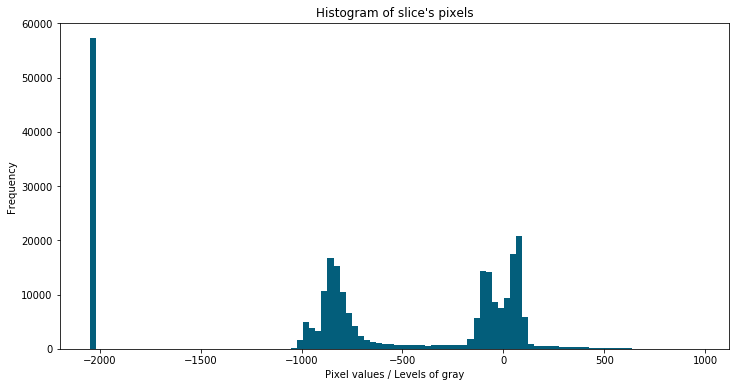

In [13]:
plt.figure(figsize=(12,6))
sns.distplot(CT_slice.flatten(), kde = False, color = '#035E7B', hist_kws={'alpha':1}, bins = 100)
plt.xlabel('Pixel values / Levels of gray')
plt.ylabel('Frequency')
plt.title("Histogram of slice's pixels");

**Note:** As we can see from the histogram, there is an amount of pixels with a value around -2000. Those pixel values correspond to the black circular frame of each slice which esentialy has nothing to do with the image. Thus an optional decision is to treat it as air.

In [14]:
CT_slice[CT_slice < -1000] = -1000

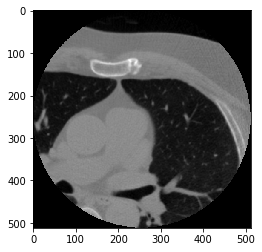

In [15]:
plt.imshow(CT_slice, cmap = 'gray');

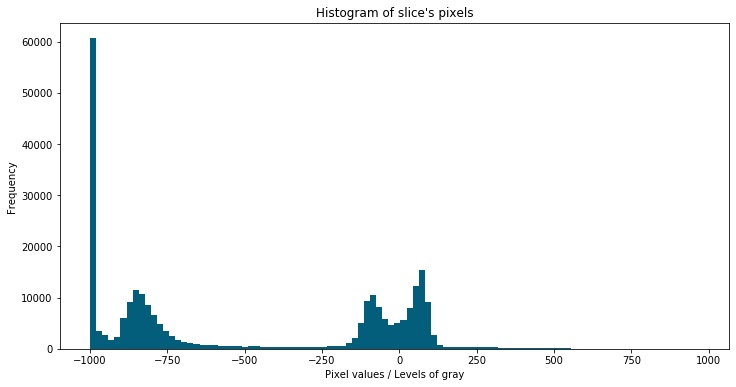

In [16]:
plt.figure(figsize=(12,6))
sns.distplot(CT_slice.flatten(), kde = False, color = '#035E7B', hist_kws={'alpha':1}, bins = 100)
plt.xlabel('Pixel values / Levels of gray')
plt.ylabel('Frequency')
plt.title("Histogram of slice's pixels");

In this section we will:

- Determine all variables needed for the segmenataion (statistical parameters, position of spine, position of aorta etc)

- Perform preliminary cleaning of the images ( through of which of the Region Of Interest)

## 1.1 Statistical parameters:



We can define a CT scan as a scalar function $f(x,y,z)$, where $x = 1, ..., N$ is the image height, $y = 1, ..., M$ is the image width and $z = 1,..., K$ is the slice number.


For the $k_{th}$ CT slice:

**(a) Mean value of intensity of pixels, $\mu(k)$:**

$\mu(k) = \frac{1}{NM} \sum_{x = 1}^{N} \sum_{y = 1}^{M} f(x,y,k)$


This value allows us to seperate the air and background from the rest of the slice.

We can create a binary mask by thresholding with  $\mu(k)$

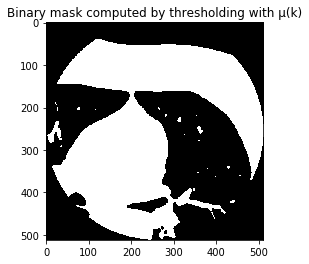

In [17]:
mu_k = CT_slice.mean()
mu_binary_mask = CT_slice > mu_k

plt.imshow(mu_binary_mask, cmap = 'gray')
plt.title('Binary mask computed by thresholding with μ(k)');

**(b) Mean intensity value of the pixels with an intensity level higher than  $\mu(k)$, $\mu_{sup}(k)$ :**

$\mu_{sup}(k)= \frac{1}{R_k} \sum_{i = 1}^{R_k} (X_i,Y_i,k)$

where $R_k$ is the number of pixels $(X_i,Y_i)$ in the $k_{th}$ slice which satisfy $f(X_i,Y_i,k)>\mu(k)$.

Can be used for obtaining a binary mask which determines the position of the spine in each image.


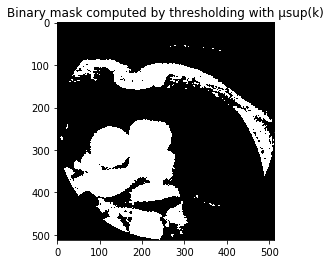

In [18]:
Rk = np.where(CT_slice.flatten() > mu_k)[0]
mu_sup_k = CT_slice.flatten()[Rk].mean()

mu_sup_binary_mask = CT_slice > mu_sup_k

plt.imshow(mu_sup_binary_mask, cmap = 'gray')
plt.title('Binary mask computed by thresholding with μsup(k)');

**(c) Standard deviation of intensities of pixels in the  $k_{th}$  slice with intensity level higher than  $\mu(k)$, $\sigma(k)$ :**

$\sigma(k) = \sqrt{ \frac{1}{R_k - 1} \sum_{i = 1}^{R_k} (f(X_i,Y_i,k) - \mu_{sup}(k))^2}$

The threshold $\mu_{sup}(k) + \sigma(k)$ allows us to obtain a binary mask which is used later in the segmentation stage in order to locate the descending aorta in all the slices of the volumetric scan. The resulting gray level is useful for separating the outer layer of the bones and the structures where oxygenated blood flows from the rest of the image.

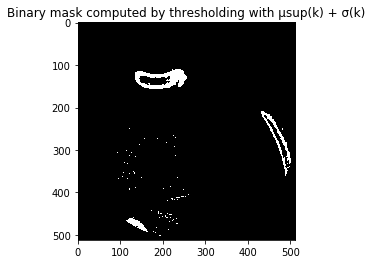

In [20]:
sigma_k = CT_slice.flatten()[Rk].std()

mu_sup_s_binary_mask = CT_slice > mu_sup_k + sigma_k

plt.imshow(mu_sup_s_binary_mask, cmap = 'gray')
plt.title('Binary mask computed by thresholding with μsup(k) + σ(k)');

In [23]:
mu_k, mu_sup_k, mu_sup_k+ sigma_k

(-497.01787185668945, -11.629983592415298, 120.65758898646158)

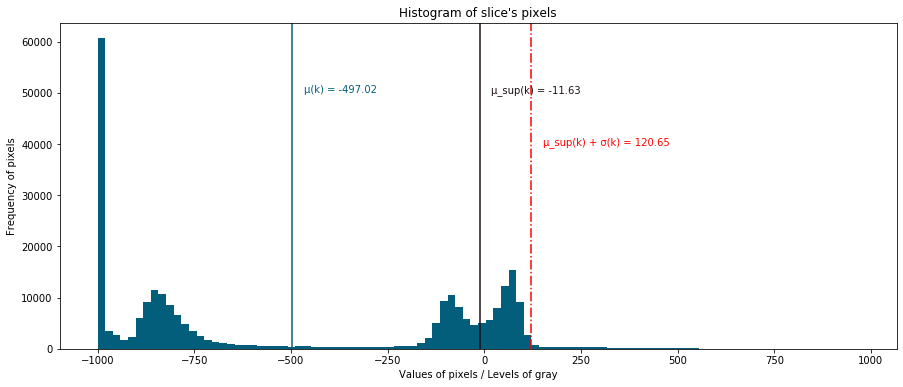

In [24]:
plt.figure(figsize = (15,6))
sns.distplot(CT_slice.flatten(), kde = False, color = '#035E7B', hist_kws={'alpha':1}, bins = 100)
plt.axvline(x = mu_k, c = '#035E7B')
plt.text(x = mu_k + 30, y = 50000, s = "μ(k) = -497.02", c = '#035E7B')
plt.axvline(x = mu_sup_k, c = '#1C1018')
plt.text(x = mu_sup_k + 30, y = 50000, s = "μ_sup(k) = -11.63", c = '#1C1018')
plt.axvline(x = mu_sup_k + sigma_k, c = 'red',linestyle = '-.' )
plt.text(x = mu_sup_k + sigma_k + 31, y = 40000, s = "μ_sup(k) + σ(k) = 120.65", c = 'red')

plt.xlabel('Values of pixels / Levels of gray')
plt.ylabel('Frequency of pixels')
plt.title("Histogram of slice's pixels");

**(d) Mean of  $\mu_{sup}(k)$  minus standard deviation of  $\mu_{sup}(k)$, $\mu_{global}$:**


$\mu_{global} = \frac{1}{K} \sum_{k=1}^{K} \mu_{sup}(k) - \sqrt{\frac{1}{K-1} \sum_{i-1}^{K} \mu_{sup}(i) - \frac{1}{P} \sum_{k-1}^{K} \mu_{sup}(k)^2}$


Thresholding with $\mu_{global}$ will show the intensities which characterize muscular tissues.

In [25]:
mu_sup_list = []
for i in range(len(CT_scan)):
    ct = CT_scan[i].pixel_array
    
    mu_k_i = ct.mean()
    Rk_i = np.where(ct.flatten() > mu_k_i)[0]
    mu_sup_k_i = ct.flatten()[Rk_i].mean()
    
    mu_sup_list.append(mu_sup_k_i)

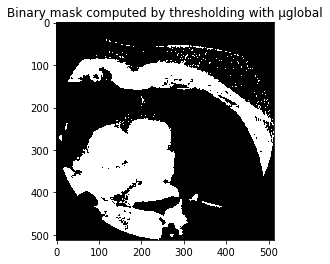

In [34]:
mu_global = np.mean(mu_sup_list) - np.std(mu_sup_list)

mu_global_binary_mask = CT_slice > mu_global

plt.imshow(mu_global_binary_mask, cmap = 'gray')
plt.title('Binary mask computed by thresholding with μglobal');

## 2.1.3 Automatic selection of the region of interest

--- 

In [35]:
def get_image_from_mask (image,mask):
    new_image = np.ones(shape = (image.shape))*(-1000)
    index = (mask == True)
    new_image[index] = image[index]
    return(new_image)

--- 

In [36]:
def highest_area_object(image, at_least_one_object = False):
    '''
- This functions checks if there is at least 1 object in an binary image and keeps only the 
  one of highest area.

    '''    
    #Label connected regions of 1s from the binary_mask (contains only 0s and 1s).
    labels = label(image)
    #tests if at least 1 object exists in image
    if at_least_one_object == True:
        assert( labels.max() != 0 ) 
    
    #create array with 1 values correspoding to bigest'objects label
    if len(np.bincount(labels.flatten())) == 1:
        return(image)
    else:
        largest_object = labels == np.argmax(np.bincount(labels.flatten())[1:])+1
        return (largest_object)

--- 

In [37]:
def return_pulses(profile):
    
    '''
 - According to the article a pulse is a sequence of 1s in each binary masked profile.
 - This function returns a list of lists cointaining all the pulses seperatly contained in each of the M profiles
 of the slice along with the list of their indexes.
 - The number of pulses is equal or greater than 0
 - In case of 0 pulses the function returns a list of a (0,0) tuple.
    
    '''
    
    stacked = np.hstack(([0], profile, [0]))
    #finds the first index of each sequence of 1s
    start = (np.diff(stacked)>0)
    #find the last index of each sequence of 1s
    end = (np.diff(stacked)<0)
    
    number_of_pulses = len(np.where(start == True)[0])
    
    pulses = []
    
    for i in range(number_of_pulses):
        #for each pulse append: 
                       #the list of i_th pulse.  
        pulses.append([profile[np.where(start == True)[0][i]:np.where(end == True)[0][i]],
                       #the list of i_th pulse's index in the profile
                   list(range(np.where(start == True)[0][i],np.where(end == True)[0][i]))])
 
    if pulses == []:
        return[(0,0)]
    else:
        return(pulses)

--- 

In [38]:
def ROI(image):
    '''
    This function takes a single CT slice and returns the region of interest.
    '''
    

    #rows and columns of k_th slice
    N, M = image.shape

    #Mean value of the intensity of the pixels, μ(k)
    mu_k = image.mean()
    
 
 #STEP 1

    #Appy binary mask on k_th slice by thresholding with μ(k)
    binary_mask = image > mu_k

 #STEP 2
    #Keep only object of highest number of pixels / highest area
    binary_mask = highest_area_object(binary_mask)

 #STEP 3 Initialiase width values

    #initialize width_mean 
    width_mean = 0.1 * N
    #initialize width_max
    width_max = 0.3 * N
    
 #STEP 4  
    #for each column of pixel array
    for j in range(M):
        #create profile
        profile = np.asarray(binary_mask[:,j])

        #leftmost pulse of the jth profile i.e. the 1rst pulse of the jth profile
        #along with the index
        first_pulse, index = return_pulses(profile)[0]
  

        #if 0 pulses in the profile do nothing
        if isinstance(first_pulse, np.ndarray) == False:
            width_mean = 0
            continue

        #set width_j as the width of leftmost pulse i.e. the number of the first (sequenced) 1s in the jth profile
        w_j = len(first_pulse)

            
        if w_j < width_max:
            #if condition met, update width_mean to be equal to width_j
            width_mean = w_j
            #set to 0 the upmost wj pixels with a value of 1 in the jth column of the binary mask
            binary_mask[index,j] = False
        
        else:
            #set to 0 the upmost wj pixels with a value of 1 in the jth column of the binary mask
            binary_mask[index[0]:index[0] + int(width_mean),j] = False   
 #STEP 6         
        
        #If after the processing there is more than one object in the resulting mask, 
        #select the largest one and discard the rest.
    #largest_object = highest_area_object(binary_mask)
    binary_mask = highest_area_object(binary_mask)
    return(binary_mask)

--- 

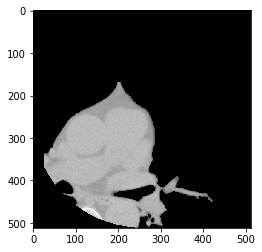

In [42]:
roi_binary_mask = ROI(CT_slice)

plt.imshow(get_image_from_mask(CT_slice,roi_binary_mask), cmap = 'gray');

In [49]:
ct_slice_roi = []
for i in range(len(ct_slices)):
    ct_slice_roi_binary = ROI(ct_slices[i])
    ct_slice_roi.append(get_image_from_mask(ct_slices[i],ct_slice_roi_binary))

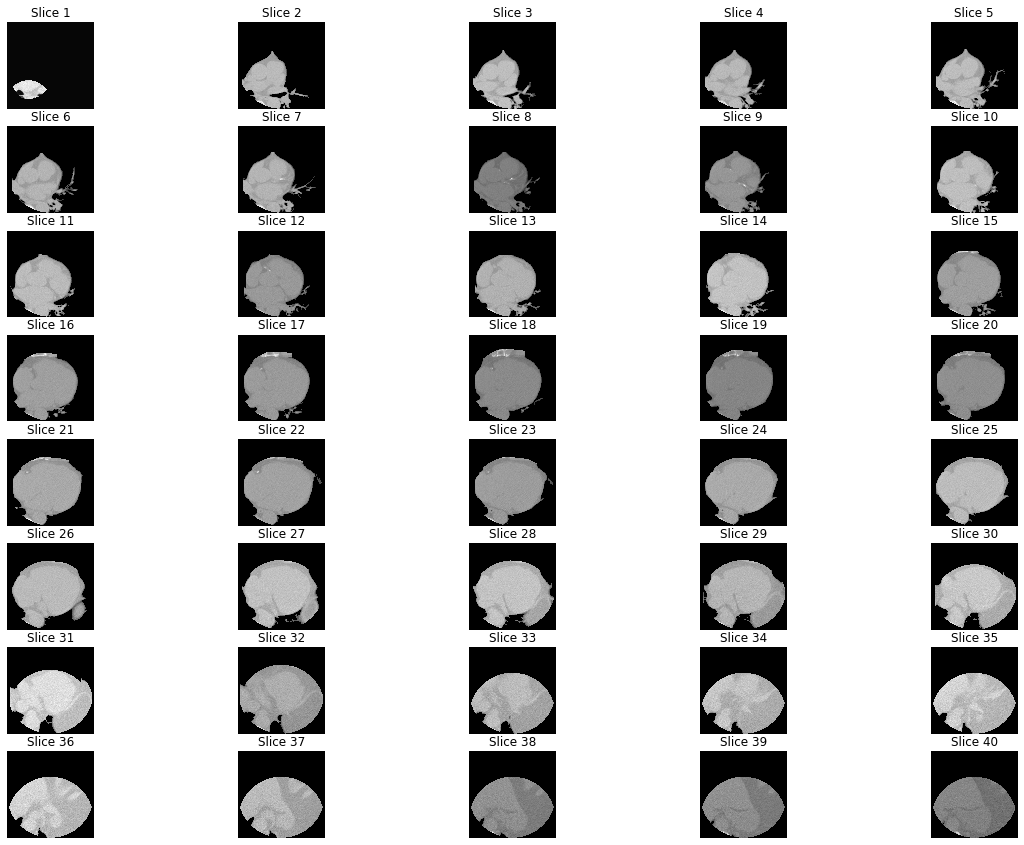

In [50]:
multiple_plots(ct_slice_roi)